# Modelling the Number of Casualties on the Roads of Great Britain

## Steps taken

1) Loading the necessary Python libraries and class for feature engineering (clean_data.py).


2) Importing the data: Accidents, Vehicles and Casualties datasets.


3) **Merging the 3 datasets on Accident_Index**. Even though the main dataset used was 'Accidents', there's a number of interesting variables in Vehicles and Casualties tables, which I will include into the model, namely:
    
    a) Average age of driver,
    
    b) Average age of vehicle,
    
    c) Average engine capacity,
    
    d) Average age of casualty.
    
    
    These variables were merged with the Accidents dataset using the Accident_Index. 
    
    
4) **Data cleaning and feature engineering**:

    a) For continuous variables, missing values were replaced with the mean.
    
    b) The hour of the accident was extracted from Time variable.
    
    c) Dummy variables were created from the categorical features.
    
    d) Created squared terms for Age variables, in order to account for potentially non-linear relationship between number of casualties and the age of driver/vehicle/casualty. Gradient Boosting Partial Dependence plots later confirmed the existence of non-linear relationship between the age of the casualty and the number of casualties. 
    
    e) To correct for the presence of outliers, log-transforming Number_of_Vehicles and Engine_Capacity.
    


5) Checked correlation coefficients between the features. All correlation cofficients were well below 0.5, indicating that multicollinearity won't be an issue in the model. 


6) Splitting the sample into **train and test samples with 70/30 ratio.**


7) Running **Linear Regression** using the train dataset. Residuals of the initial model seemed to suffer from heteroscedasticity (not constant variance), possibly due to the presence of outliers in the target variable. To solve the issue, I took the logs of the target variable and checked residuals again. They now looked better. Also, log-transforming the target variable resulted in a 2% higher R-square.


8) Checking the statistical significance of the variables in the model. Removed the variables that were not significant under 95% confidence level (p-val>0.05). Insignificant variables were removed from the model one-by-one starting from the least significant one. 


9) Checked the coefficient signs of the remaining variables. **All coefficients displayed expected signs**. **R-squared** was equal to 0.12, indicating that features explained **12%** of variation in the target variable. 


10) Performed 5-fold **cross-validation** on the train dataset and calculated the average **MSE (mean squared error)**.


11) Calculated MSE of the test dataset. Both, train and test MSEs were very close, indicating that overfitting is not an issue.


12) Fitted **Gradient Boosting Regressor** to see whether feature importances corresponded to the Linear Regression results and whether Gradient Boosting would produce an improved MSE, which it did. It also provided useful insights about the most important predictors and about the relationships between the target variable and each of the features. 

## Linear Regression and Gradient Boosting Results Interpretation

Feature interpretations are based on the Linear regression model with log-transformed target variable. Log-transformation of the target variable improved the residuals and the R-squared of the Linear Regression. Gradient Boosting Feature Importance ranking and Partial Dependence plots provided additional useful insights about the predictors of the number of casualties. 

**Top 10 most important predictors of the number of casualties:**

1) **The number of vehicles**: Higher number of vehicles involved in an accident associated with a higher number of reported casualties. Linear regression coefficient estimate implied that a 1% increase in the number of vehicles associated with 0.24% increase in the number of reported casualties, i.e. additional vehicle in an accident was associated with a 24% increase in the number of casualties. Both, the number of vehicles and the target variable were log-transformed, therefore the relationship can be interpreted directly in percentage terms.  

2) **Age of casualty**: This significant feature displayed a non-linear relationship with the number of casualties, and was quantified by adding a squared term into the regression. Partial dependence plot revealed that as the average age of casualty approched 30, the number of the reported casualties rose, then peaked and dropped thereafter. This result makes sense, because younger people, especially teenagers, tend to be less careful and often walk or drive in groups.

3) **Engine capacity**: Greater engine capacity was associated with a higher number of reported casualties.

4) **Speed limit**: Areas with a higher speed limit reported more casualties.

5) **A police officer attending the scene of the accident** associated with 8% higher number of reported casualties. One explanation for it could be that some casualties tend to go unreported in the absence of a police officer. Calculation: (exp(0.0789) - 1) = 0.08

6) **Accident severity**: Fatal and serious accidents were associated with 22% and 6.5% higher number of casualties than slight accidents, respectively. Calculation: (exp(0.1997) - 1) = 0.22 and (exp(0.0625) - 1) = 0.065

7) **Age of the driver**: Older drivers were associated with a lower number of reported casualties.

8) An accident in an **urban area** was associated with a 3% lower number of casualties than an accident in a rural area. Calculation: (exp(0.028)-1)*100

9) **Local authority district**: Some districts (Birmingham, Leeds, Bradford) were associated with higher numbers of reported casualties, while others (Westminister, Glasgow) - with lower ones. 

10) **Age of the vehicle**: Older vehicles were associated with a higher number of reported casualties.


Other significant features:

11) **Mondays** were associated with a higher number of reported casualties. Although Monday dummy variable was ommited from the Linear Regression model, all other 'day of the week' dummies displayed negative coefficients *in comparison to Monday*.

12) **Early morning hours** were associated with a lower number of casualties. The accidents happening between 6-7AM and 7-8AM tend to have 12% lower numbers of casualties. 

13) Accidents happening on **crossroads** (6.0 Junction detail) were associated with 4% more reported casualties than spots without a junction or a junction within 20 metres.

14) **Light condition** 'Darkness - no lighting' was associated with 2% higher number of reported casualties. 


In [1]:
import pandas as pd
import numpy as np
import datetime
import os
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import signal
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from clean_data import CleanData

### Importing the data

In [2]:
#Accidents dataset
acc0514 = pd.read_csv('data/Acc0514.csv', parse_dates=['Date'])
acc15 = pd.read_csv('data/Acc15.csv', parse_dates=['Date'])
acc16 = pd.read_csv('data/Acc16.csv', parse_dates=['Date'])
acc17 = pd.read_csv('data/Acc17.csv', parse_dates=['Date'])

frames = [acc0514, acc15, acc16, acc17]
acc = pd.concat(frames)

#Casualties dataset
cas0514 = pd.read_csv('data/Cas0514.csv')
cas15 = pd.read_csv('data/Cas15.csv')
cas16 = pd.read_csv('data/Cas16.csv')
cas17 = pd.read_csv('data/Cas17.csv')

frames = [cas0514, cas15, cas16, cas17]
cas = pd.concat(frames)

#Vehicles dataset
veh0514 = pd.read_csv('data/Veh0514.csv')
veh15 = pd.read_csv('data/Veh15.csv')
veh16 = pd.read_csv('data/Veh16.csv')
veh17 = pd.read_csv('data/Veh17.csv')

frames = [veh0514, veh15, veh16, veh17]
veh = pd.concat(frames)

### Feature engineering: done in clean_data.py 

In [3]:
data = CleanData().merge_tables(acc, veh, cas)
data = CleanData().missing_values(data)
selected_data = CleanData().features(data)

### Define features matrix X and the target variable y

In [5]:
X = selected_data.drop('Number_of_Casualties', axis=1)
y = selected_data['Number_of_Casualties']

### Splitting the data into train and test datasets

In [58]:
#Train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)   

# Fitting linear regression: initial results

In [59]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

### Cross-validation and residual scatter plot

0.5877017762382346
0.6449042564596195


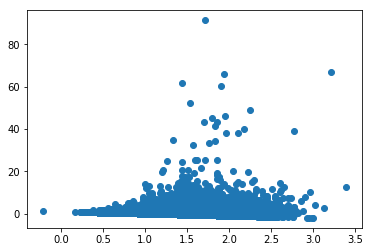

In [60]:
# Train error
cv_mses = (cross_val_score(model,X_train,y_train,cv=5,
                                   scoring='neg_mean_squared_error'))*-1
print(np.mean(cv_mses))

# Test error
y_predicted = model.predict(X_test)
print(mean_squared_error(y_test,y_predicted))

# Residual scatter plot
plt.scatter(y_predicted,y_test-y_predicted)

The residuals tend to rise as the target variable increases (residual variance is not constant), indicating that heteroscedasticity may be a problem. 

### Linear Regression Model Summary
One way to deal with outliers in the target variable is log-transforming it. However, before doing it, let's look at the current model summary. Python StatsModels was used to display the model summary.

Note: In the code below you will see that some features were dropped from the model. That is because they were not significant under 95% confidence level and thus were removed from the regression one-by-one starting from the least significant one.

In [61]:
X_train_lr=X_train.drop(['4.0_weather','6.0_weather', '5.0_weather', '1.0_hr',
         'Ped_Cross_None_Human_control','9.0_junction_detail','7.0_weather',
         '22.0_hr','2.0_hr','3.0_hr','3.0_junction_detail','1.0_junction_control'], axis=1)

X_train_lr = sm.add_constant(X_train_lr)
model = sm.OLS(y_train,X_train_lr.astype(float))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Number_of_Casualties   R-squared:                       0.102
Model:                              OLS   Adj. R-squared:                  0.102
Method:                   Least Squares   F-statistic:                     2382.
Date:                  Mon, 20 May 2019   Prob (F-statistic):               0.00
Time:                          02:50:06   Log-Likelihood:            -1.6017e+06
No. Observations:               1389056   AIC:                         3.204e+06
Df Residuals:                   1388989   BIC:                         3.204e+06
Df Model:                            66                                         
Covariance Type:              nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.4415      0.012     37.912      0.000       0.419       0.464
1.0_road_surface               -0.0325      0.002    -18.156      0.000      -0.036      -0.029
2.0_weather                     0.0066      0.002      2.661      0.008       0.002       0.011
3.0_weather                    -0.0224      0.008     -2.750      0.006      -0.038      -0.006
8.0_weather                    -0.0091      0.005     -1.961      0.050      -0.018   -2.84e-06
9.0_weather                    -0.0332      0.005     -7.089      0.000      -0.042      -0.024
6.0_light                       0.0396      0.003     12.215      0.000       0.033       0.046
1.0_2nd_road_class             -0.0149      0.008     -1.761      0.078      -0.031       0.002
1.0_junction_detail            -0.0500      0.004    -13.211      0.000      -0.057      -0.043
2.0_junction_detail             0.0152      0.007      2.242      0.025       0.002       0.029
5.0_junction_detail            -0.0293      0.006     -5.119      0.000      -0.040      -0.018
6.0_junction_detail             0.0749      0.002     32.161      0.000       0.070       0.079
7.0_junction_detail             0.0559      0.006      9.417      0.000       0.044       0.068
8.0_junction_detail            -0.0478      0.004    -13.486      0.000      -0.055      -0.041
1.0_roadtype                   -0.0542      0.004    -12.537      0.000      -0.063      -0.046
1.0_1st_road_class              0.0074      0.004      1.931      0.054      -0.000       0.015
4.0_hr                         -0.0786      0.009     -8.645      0.000      -0.096      -0.061
5.0_hr                         -0.1586      0.008    -20.897      0.000      -0.173      -0.144
6.0_hr                         -0.2087      0.006    -37.768      0.000      -0.220      -0.198
7.0_hr                         -0.2049      0.004    -49.484      0.000      -0.213      -0.197
8.0_hr                         -0.1393      0.004    -38.589      0.000      -0.146      -0.132
9.0_hr                         -0.1308      0.004    -33.027      0.000      -0.139      -0.123
10.0_hr                        -0.0798      0.004    -19.596      0.000      -0.088      -0.072
11.0_hr                        -0.0654      0.004    -16.674      0.000      -0.073      -0.058
12.0_hr                        -0.0613      0.004    -16.196      0.000      -0.069      -0.054
13.0_hr                        -0.0549      0.004    -14.640      0.000      -0.062      -0.048
14.0_hr                        -0.0504      0.004    -13.455      0.000      -0.058      -0.043
15.0_hr                        -0.0487      0.004    -13.748      0.000      -0.056      -0.042
16.0_hr                        -0.0665      0.003    -19.067      0.000      -0.073  

# Fitting linear regression: results with log-transformed target variable
Now let's check if log-tranforming the target variable would give us any improvement. Numpy library (np.log) was used to transform the target variable.

0.1345497288910273
0.13477715447093044


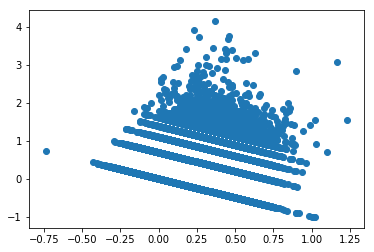

In [62]:
model = LinearRegression()
model.fit(X_train,np.log(y_train)) #np.log(y_train)!!!

# Train error
cv_mses = (cross_val_score(model,X_train,np.log(y_train),cv=5,
                                   scoring='neg_mean_squared_error'))*-1
print(np.mean(cv_mses))

# Test error
y_predicted = model.predict(X_test)
print(mean_squared_error(np.log(y_test),y_predicted))

# Residual scatter plot
plt.scatter(y_predicted,np.log(y_test)-y_predicted)

These log-transformed residuals do not suffer from the issue of spurious outliers we saw in the previous residuals scatter plot. Now let's take a look at the new Linear Regression model summary.

In [64]:
X_train_lr=X_train.drop(['4.0_weather','6.0_weather', '1.0_hr',
         'Ped_Cross_None_Human_control','9.0_junction_detail','7.0_weather',
         '22.0_hr','2.0_hr','3.0_hr','3.0_junction_detail','1.0_junction_control'], axis=1)

X_train_lr = sm.add_constant(X_train_lr)
model = sm.OLS(np.log(y_train),X_train_lr.astype(float))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Number_of_Casualties   R-squared:                       0.120
Model:                              OLS   Adj. R-squared:                  0.120
Method:                   Least Squares   F-statistic:                     2821.
Date:                  Mon, 20 May 2019   Prob (F-statistic):               0.00
Time:                          02:54:25   Log-Likelihood:            -5.7780e+05
No. Observations:               1389056   AIC:                         1.156e+06
Df Residuals:                   1388988   BIC:                         1.157e+06
Df Model:                            67                                         
Covariance Type:              nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -0.2539      0.006    -45.542      0.000      -0.265      -0.243
1.0_road_surface               -0.0192      0.001    -21.698      0.000      -0.021      -0.017
2.0_weather                     0.0029      0.001      2.396      0.017       0.001       0.005
3.0_weather                    -0.0084      0.004     -2.166      0.030      -0.016      -0.001
5.0_weather                    -0.0058      0.003     -2.108      0.035      -0.011      -0.000
8.0_weather                    -0.0041      0.002     -1.834      0.067      -0.008       0.000
9.0_weather                    -0.0207      0.002     -9.221      0.000      -0.025      -0.016
6.0_light                       0.0216      0.002     13.905      0.000       0.019       0.025
1.0_2nd_road_class             -0.0072      0.004     -1.779      0.075      -0.015       0.001
1.0_junction_detail            -0.0257      0.002    -14.200      0.000      -0.029      -0.022
2.0_junction_detail             0.0088      0.003      2.718      0.007       0.002       0.015
5.0_junction_detail            -0.0135      0.003     -4.919      0.000      -0.019      -0.008
6.0_junction_detail             0.0424      0.001     38.069      0.000       0.040       0.045
7.0_junction_detail             0.0312      0.003     10.996      0.000       0.026       0.037
8.0_junction_detail            -0.0231      0.002    -13.600      0.000      -0.026      -0.020
1.0_roadtype                   -0.0290      0.002    -14.034      0.000      -0.033      -0.025
1.0_1st_road_class             -0.0072      0.002     -3.923      0.000      -0.011      -0.004
4.0_hr                         -0.0408      0.004     -9.387      0.000      -0.049      -0.032
5.0_hr                         -0.0858      0.004    -23.614      0.000      -0.093      -0.079
6.0_hr                         -0.1100      0.003    -41.623      0.000      -0.115      -0.105
7.0_hr                         -0.1059      0.002    -53.467      0.000      -0.110      -0.102
8.0_hr                         -0.0728      0.002    -42.145      0.000      -0.076      -0.069
9.0_hr                         -0.0659      0.002    -34.796      0.000      -0.070      -0.062
10.0_hr                        -0.0397      0.002    -20.378      0.000      -0.044      -0.036
11.0_hr                        -0.0314      0.002    -16.722      0.000      -0.035      -0.028
12.0_hr                        -0.0279      0.002    -15.442      0.000      -0.031      -0.024
13.0_hr                        -0.0258      0.002    -14.366      0.000      -0.029      -0.022
14.0_hr                        -0.0226      0.002    -12.599      0.000      -0.026      -0.019
15.0_hr                        -0.0230      0.002    -13.563      0.000      -0.026  

The new regression model has 2% higher R-squared and an additional significant feature: Raining + High Winds Weather dummy variable (5.0_weather) is now significant under 95% confidence level.

# Gradient Boosting Regressor
Gradient Boosting Regressor could help us understand better the main factors influencing the number of casualties on the roads of Great Britain and help us make better predictions. One nice aspect to the Gradient Boosting Regressor, and decision trees in general, is that it does not require creation of the dummy variables from categorical features. As long as the features contain numeric values, the model will fit. 

The only issues left to take care of were some missing values in Time variable and log-transformation of the highly skewed Number_of_Vehicles variable. (Note: I ran the model with both, plain and log-transformed Number_of_Vehicles. Taking logs improved the test MSE).

More on Gradient Boosting: In boosting, trees are grown sequentially: each tree is grown using information from the previously grown trees. Boosting does not involve bootstrap sampling; instead each tree is fit on a modified version of the original data set. Unlike fitting a single large decision tree to the data, which amounts to fitting the data hard and potentially overfitting, the boosting approach instead learns slowly. Given the current model, we fit a decision tree to the residuals from the model. That is, we fit a tree using the current residuals, rather than the outcome Y, as the response. We then add this new decision tree into the fitted function in order to update the residuals. Each of those trees can be rather small, with just few terminal nodes, determined by the parameter d in the algorithm. By fitting small trees to the residuals, we slowly improve the fitted function f^ in areas where it does not perform well. The shrinkage parameter lambda slows the process down even further, allowing more and different shaped trees to attack the residuals. In general, statistical learning approaches that learn slowly tend to perform well. In boosting, unlike in bagging, the construction of each tree depends strongly on the trees that have already been grown.

### Feature engineering: done in clean_data.py 

In [100]:
selected_data = CleanData().features_gbr(data)

### Define features matrix X and the target variable y

In [101]:
X = selected_data.drop('Number_of_Casualties', axis=1)
y = selected_data['Number_of_Casualties']

### Splitting the data into train and test datasets

In [102]:
#Train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)   

### Fitting Gradient Boosting Regressor
I would like compare the performance (MSE) of the Gradient Boosting Regressor model and the Linear Regression model, therefore I use log-transformed target variable for consistency purposes.

In [104]:
# Gradient Boosting Regressor
gdbr = GradientBoostingRegressor(learning_rate=0.1,
                                  max_depth=5,
                                  n_estimators=100,
                                  min_samples_leaf=2000,
                                  max_features=5)

gdbr.fit(X_train, np.log(y_train))

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=5,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=2000,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

### Cross-validation and residual scatter plot

0.12255095190816875
0.1227358777067026


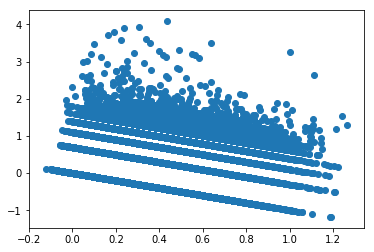

In [105]:
#Train error
cv_mses = (cross_val_score(gdbr,X_train,np.log(y_train),cv=5,
                                   scoring='neg_mean_squared_error'))*-1
print(np.mean(cv_mses))

#Test error
y_predicted = gdbr.predict(X_test)
print(mean_squared_error(np.log(y_test),y_predicted))

plt.scatter(y_predicted,np.log(y_test)-y_predicted)

Gradient Boosting Regressor improved the predictions as evident from the smaller MSEs than the ones we saw in the Linear Regression model. 

### Gradient Boosting Feature Importance ranking
Another helpful way to interpret the results and explore which explanatory variables contributed the most to the prediction of the number of casualties is the Gradient Boosting Feature Importance ranking. Feature importance scores are straightforward to retrieve after the boosted trees are constructed. The variables are ranked in ascending order, based on the number of times a variable is selected for splitting, weighted by the squared improvement to the model as a result of each split, and averaged over all trees.

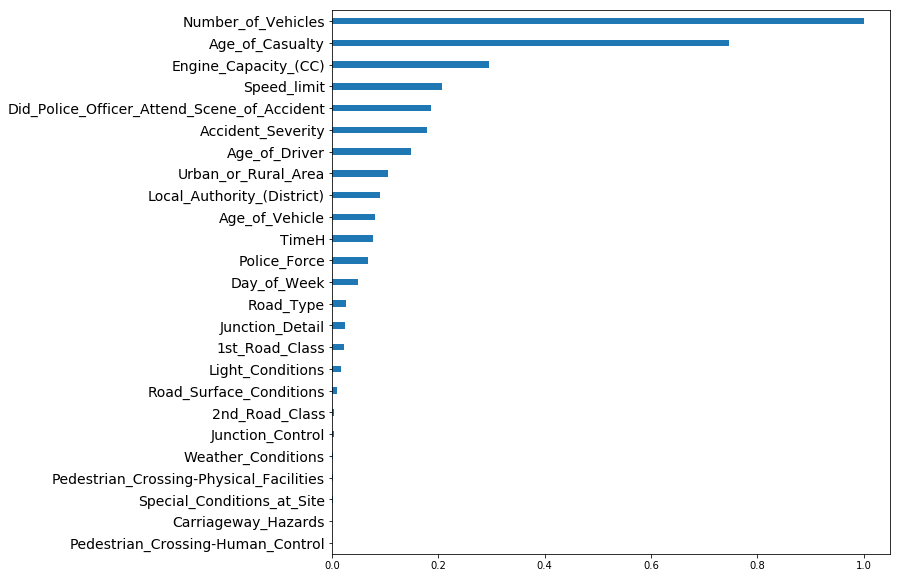

In [106]:
top_cols = np.argsort(gdbr.feature_importances_)
importances =gdbr.feature_importances_[top_cols]
fig = plt.figure(figsize=(10, 10))
x_ind = np.arange(importances.shape[0])
plt.barh(x_ind, importances/importances[-1:], height=.3, align='center')
plt.ylim(x_ind.min() -0.5, x_ind.max() + 0.5)
plt.yticks(x_ind, X_test.columns[top_cols], fontsize=14)
plt.show()

Gradient Boosting Regressor results are in line with the Linear Regression results. The most important features are the ones which displayed the largest t-statistics (ie coefficients were the most statistically different from zero) in the Linear Regression model. 

### Gradient Boosting Partial Dependence Plots
A partial dependence plot can show whether the relationship between the target and a feature is linear, monotonous or more complex.
The age of casualty displays a clearly non-linear relationship with the number of casualties. The number of casualties rises as the age approches 30, and drops thereafter. Which makes sense, as younger people, especially teenagers, tend to be less careful and often walk or drive in groups.

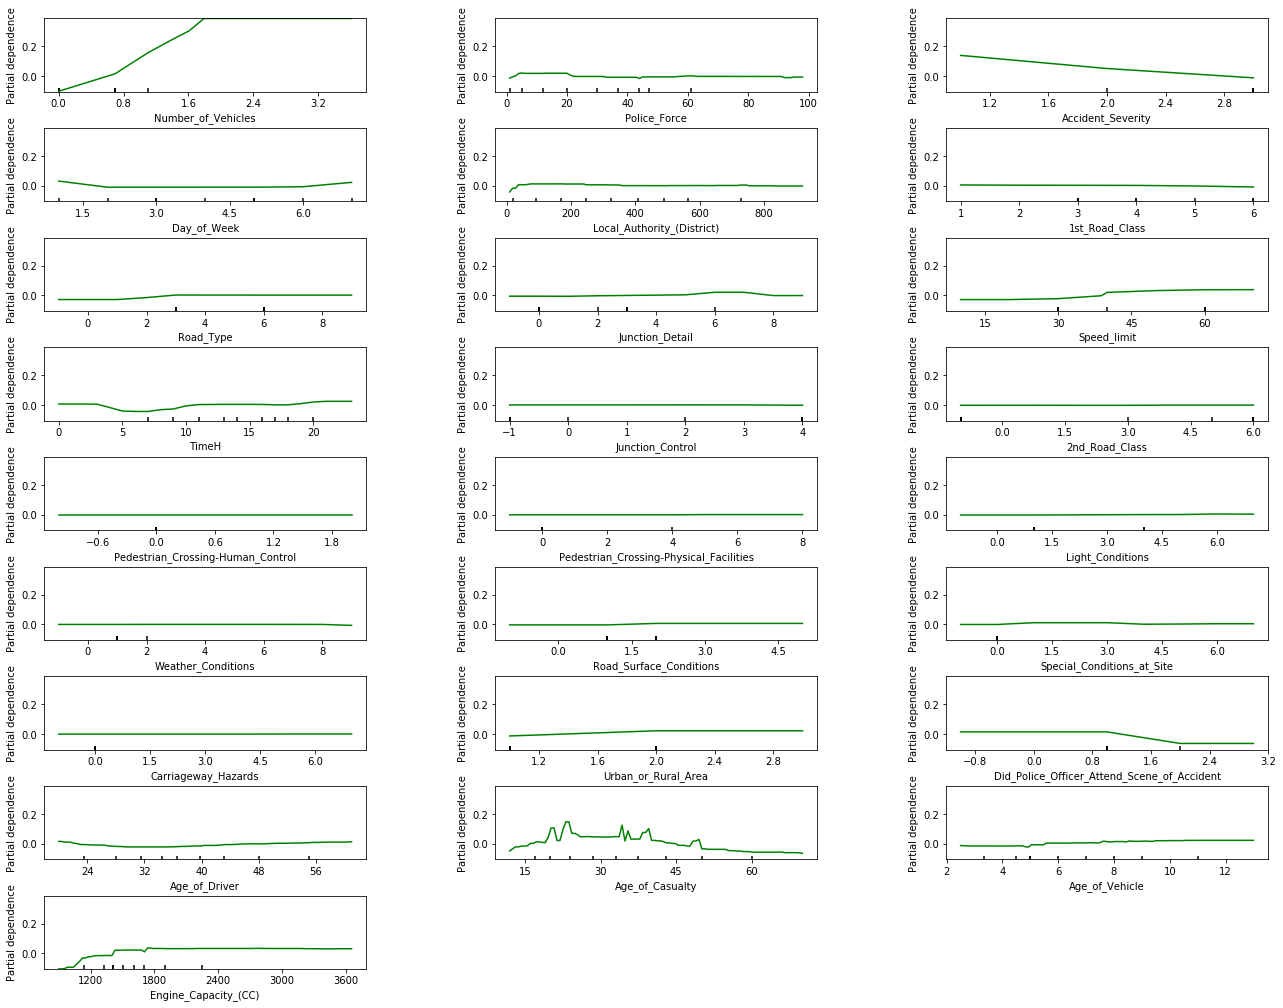

In [107]:
fig, axs = plot_partial_dependence(gdbr, X_train, np.arange(X_train.shape[1]),
                    n_jobs=3, grid_resolution=100,feature_names = X_train.columns)
fig.set_size_inches((20,24))
plt.subplots_adjust(hspace=0.5)